## Sample test simulation

This notebook contains the basic syntax required to run a chain. We set up a mock data object from a test sim, construct an emulator and likelihood object, and pass these to a sampler to run for a small number of steps.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
import time
# our own modules
from lace.archive import gadget_archive
from lace.archive import nyx_archive
from lace.emulator import gp_emulator
from lace.emulator import nn_emulator
from cup1d.data import data_gadget
from cup1d.data import data_nyx
from cup1d.likelihood import lya_theory
from cup1d.likelihood import likelihood
from cup1d.likelihood import emcee_sampler

### Set up mock data

Begin by picking a simulation to use as mock data, and creating a corresponding data object

In [2]:
# specify simulation to use to generate synthetic data
test_sim_label="central"
if type(test_sim_label)==int:
    drop_sim=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim))
else:
    drop_sim=None

In [3]:
# specify simulation suite and P1D mesurements
use_nyx=False
if use_nyx:
    emulator_label='Cabayol23_Nyx'
    archive=nyx_archive.NyxArchive(verbose=True)
else:
    emulator_label='Cabayol23'
    archive=gadget_archive.GadgetArchive(postproc='Cabayol23')

In [15]:
# setup emulator
use_gp=False
if use_gp:
    if use_nyx:
        raise ValueError('can not use GP with Nyx emulator')
    emulator=gp_emulator.GPEmulator(archive=archive,emulator_label=emulator_label,drop_sim=drop_sim)
else:
    emulator=nn_emulator.NNEmulator(archive=archive,emulator_label=emulator_label,drop_sim=drop_sim)

Select emulator in Cabayol23
Neural network emulating the optimal P1D of Gadget simulations fitting coefficients to a 5th degree polynomial. It goes to scales of 4Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones
Use custom archive provided by the user
Training samples in archive : 9900


In [16]:
# setup mock data from sim 
z_max=4.5
data_label='Chabanier2019'
if use_nyx:
    data=data_nyx.Nyx_P1D(archive=archive,sim_label="nyx_"+str(test_sim_label),
                                z_max=z_max,data_cov_label=data_label,
                                polyfit_kmax_Mpc=emulator.kmax_Mpc,
                                polyfit_ndeg=emulator.ndeg)
else:
    data=data_gadget.Gadget_P1D(archive=archive,sim_label="mpg_"+str(test_sim_label),
                                z_max=z_max,data_cov_label=data_label,
                                polyfit_kmax_Mpc=emulator.kmax_Mpc,
                                polyfit_ndeg=emulator.ndeg)

### Set up a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and emulator objects to the likelihood.

In [17]:
free_param_names=["As","ns","ln_tau_0"]
#free_param_names=["As","ns","ln_tau_0","ln_tau_1","ln_tau_2"]

In [18]:
# option to include/remove a Gaussian prior (in unit cube)
prior_Gauss_rms=None
# option to include/ignore emulator covariance (it might bias the results)
emu_cov_factor=0
like=likelihood.Likelihood(data=data,emulator=emulator,
                           free_param_names=free_param_names,
                           prior_Gauss_rms=prior_Gauss_rms,
                           emu_cov_factor=emu_cov_factor)

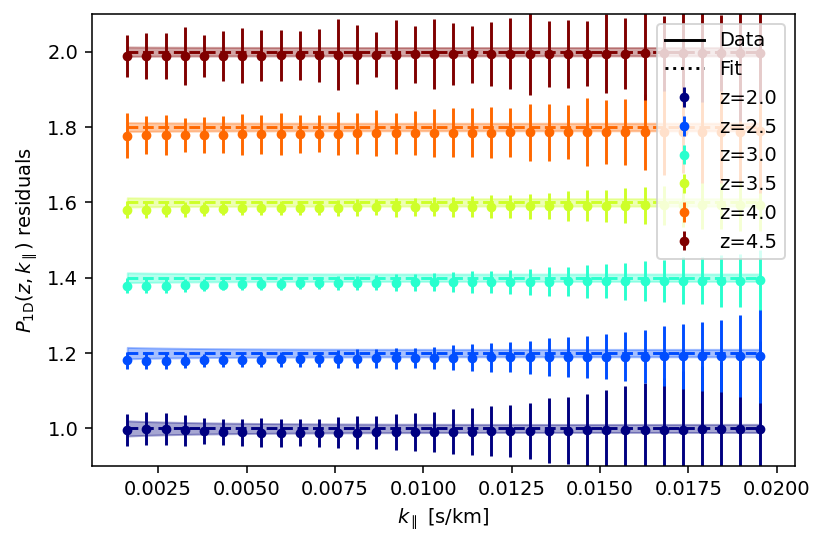

In [19]:
like.plot_p1d(residuals=True,plot_every_iz=2)

### Sampler object

Here we configure our sampler, set the number of walkers, and decide whether or not we want to save the chain to be resumed or plot later on.

In [20]:
# Set up sampler
sampler = emcee_sampler.EmceeSampler(like=like,progress=True)

Created directory: /Users/font/Codes/igmhub/cup1d//chains//chain_15
setup with 12 walkers


In [21]:
for p in sampler.like.free_params:
    print(p.name,p.value,p.min_value,p.max_value)

As 2.1e-09 1e-09 3.2e-09
ns 0.965 0.88 1.05
ln_tau_0 0.0 -0.1 0.1


In [22]:
n_burn_in=50
n_steps=500
start = time.time()
sampler.run_sampler(n_burn_in,n_steps,parallel=False)
end = time.time()
sampler_time = end - start
print("Sampling took {0:.1f} seconds".format(sampler_time))

100%|█████████████████████████████████████████| 550/550 [03:21<00:00,  2.72it/s]

Sampling took 202.2 seconds


Mean values: [0.43566075886009076, 0.49936994984839334, 0.5144040261890799]


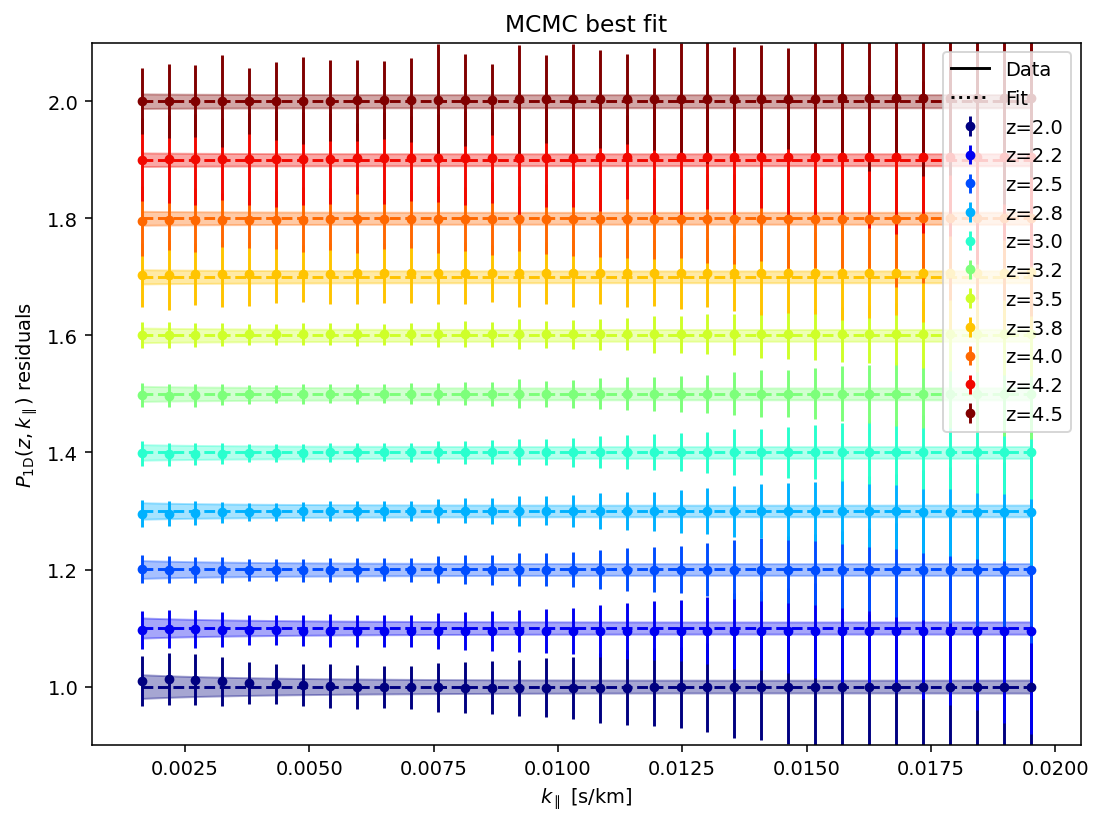

<Figure size 840x560 with 0 Axes>

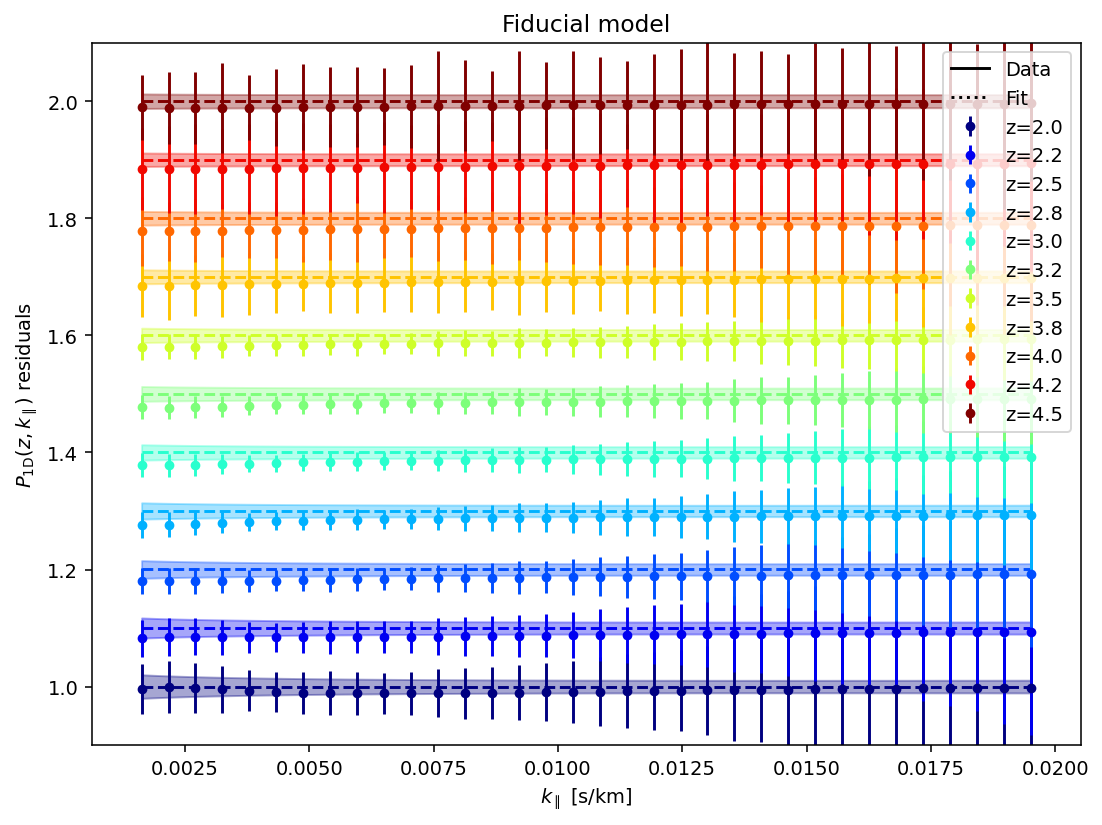

 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/chainconsumer/plotter.py:1026: UserWarning:Attempting to set identical bottom == top == 0.9815916724832918 results in singular transformations; automatically expanding.
 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/chainconsumer/plotter.py:1029: UserWarning:Attempting to set identical left == right == 0.9815916724832918 results in singular transformations; automatically expanding.
 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/chainconsumer/plotter.py:1026: UserWarning:Attempting to set identical bottom == top == 0.9680008579459802 results in singular transformations; automatically expanding.
 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/chainconsumer/plotter.py:1029: UserWarning:Attempting to set identical left == right == 0.9680008579459802 results in singular transformations; automatically expanding.
 /Users/font/opt/anaconda3/envs/lace_env/lib/pyt

Can't plot corner


<Figure size 840x560 with 0 Axes>

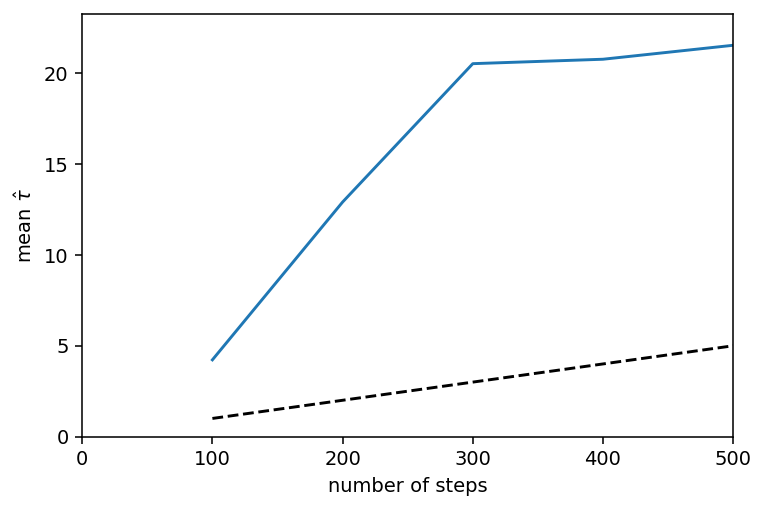

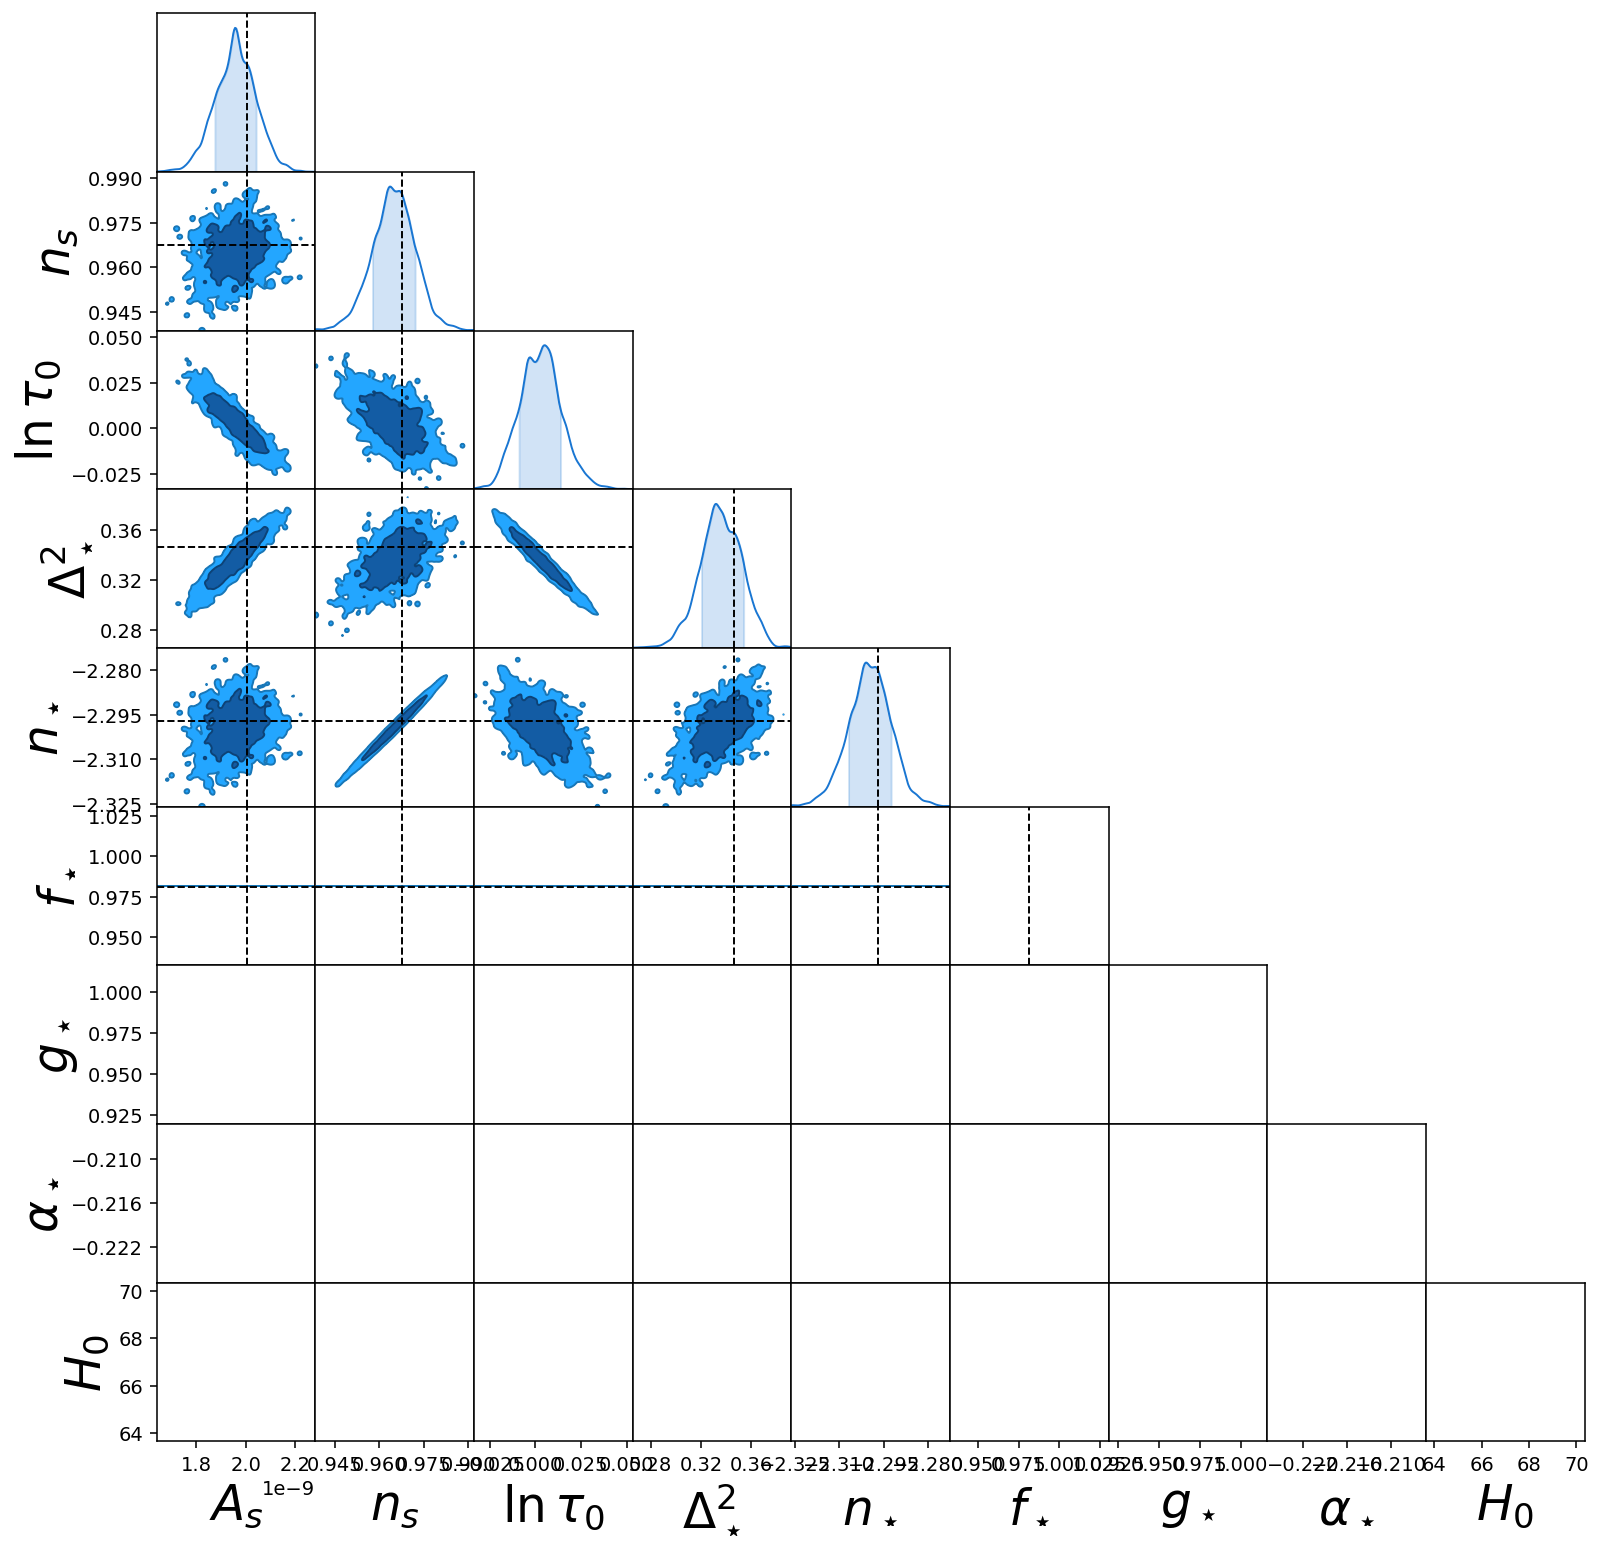

In [23]:
sampler.write_chain_to_file(residuals=True,plot_nersc=True,plot_delta_lnprob_cut=50)

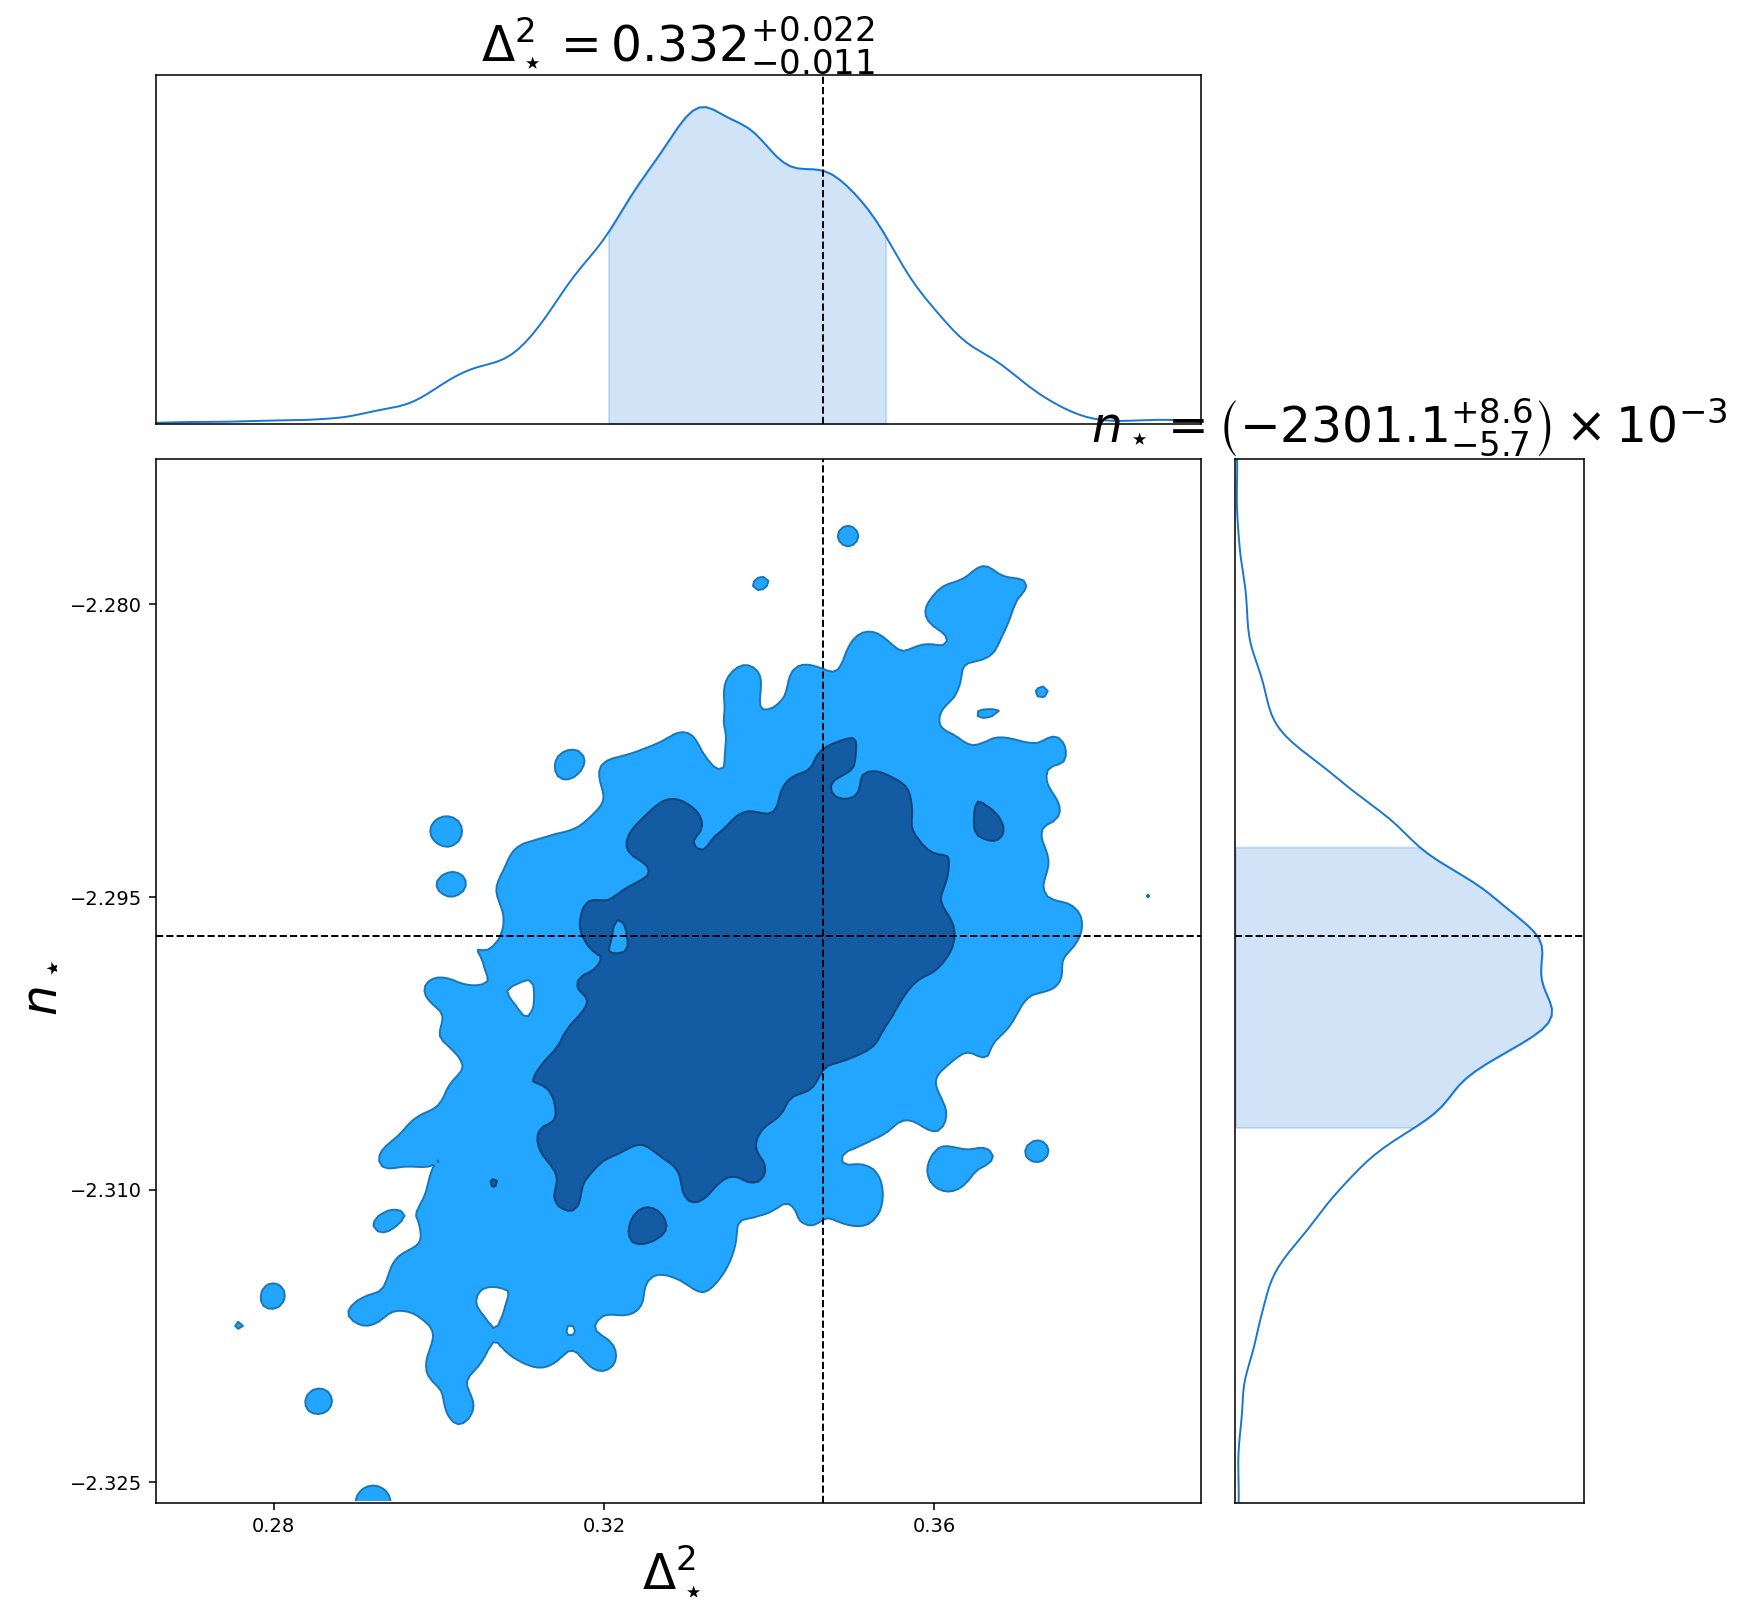

In [24]:
sampler.plot_corner(plot_params=['$\\Delta^2_\\star$','$n_\\star$'],
                    delta_lnprob_cut=50,usetex=False,serif=False)